In [1]:
import numpy as np
import pandas as pd
import itertools
import statsmodels.api as sm
from statsmodels.regression.mixed_linear_model import MixedLM
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN, HDBSCAN, MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import SpectralClustering

In [2]:
from data_load import Data
load = Data()
load.HOMES_FOR_SALE()
load.INCOME()
load.HOMICIDES()
load.POPULATION()
load.ZIP_COUNTY()

Loading: C:\Users\ej_la\.cache\kagglehub\datasets\ahmedshahriarsakib\usa-real-estate-dataset\versions\25\realtor-data.zip.csv
200 https://www.huduser.gov/hudapi/public/usps?type=2&query=All


In [3]:
from Final_Data_Output import Final_Data as FD
FD = FD()
Master_df = FD.Merge_all(min_price=100000, max_bed=12, max_bath=10, max_sqft=4000, min_sqft=1)
Master_df['log_price'] = np.log(Master_df['price'])
Master_df = Master_df.loc[Master_df['acre_lot'] < 10, :]
Master_df.info()

c:\Users\ej_la\Documents\Comp_Data_Analysis\House_Prices_Project\Final_Data_Output.py:95: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Homicides'] = df['Homicides'].fillna(0)


<class 'pandas.core.frame.DataFrame'>
Index: 963844 entries, 0 to 981362
Data columns (total 55 columns):
 #   Column                 Non-Null Count   Dtype   
---  ------                 --------------   -----   
 0   Unnamed: 0_x           963844 non-null  int64   
 1   brokered_by            963844 non-null  float64 
 2   status                 963844 non-null  object  
 3   price                  963844 non-null  float64 
 4   bed                    963844 non-null  float64 
 5   bath                   963844 non-null  float64 
 6   acre_lot               963844 non-null  float64 
 7   street                 963844 non-null  float64 
 8   city_x                 963844 non-null  object  
 9   state_x                963844 non-null  object  
 10  zip_code               963844 non-null  float64 
 11  house_size             963844 non-null  float64 
 12  prev_sold_date         963844 non-null  object  
 13  Households             956941 non-null  float64 
 14  Total_AGI              95

In [4]:
df = Master_df[['bed', 'bath', 'house_size', 'acre_lot', 'zip_code', 'Household_AGI', 'Total_Pop', 'Homicides', 'log_price']]
df = df.dropna()
df = sm.add_constant(df)
df.shape

(956915, 10)

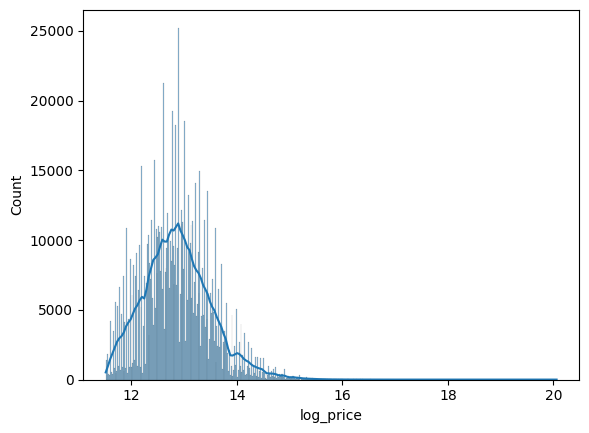

In [5]:
sns.histplot(df['log_price'], kde=True)
plt.show()

In [6]:
df.corr()

,const,bed,bath,house_size,acre_lot,zip_code,Household_AGI,Total_Pop,Homicides,log_price
const,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bed,NaN,1.000000,0.530848,0.625519,-0.023559,-0.046654,0.017098,0.077822,-0.032330,0.283731
bath,NaN,0.530848,1.000000,0.709980,0.012711,-0.018751,0.193412,0.079379,0.011956,0.463718
house_size,NaN,0.625519,0.709980,1.000000,0.076723,-0.014050,0.179472,0.027526,-0.039189,0.466958
acre_lot,NaN,-0.023559,0.012711,0.076723,1.000000,-0.036563,-0.002194,-0.198543,-0.071239,0.026261
zip_code,NaN,-0.046654,-0.018751,-0.014050,-0.036563,1.000000,0.051750,0.205965,0.275449,0.272049
Household_AGI,NaN,0.017098,0.193412,0.179472,-0.002194,0.051750,1.000000,-0.073603,0.075849,0.473775
Total_Pop,NaN,0.077822,0.079379,0.027526,-0.198543,0.205965,-0.073603,1.000000,0.227860,0.139038
Homicides,NaN,-0.032330,0.011956,-0.039189,-0.071239,0.275449,0.075849,0.227860,1.000000,0.163343
log_price,NaN,0.283731,0.463718,0.466958,0.026261,0.272049,0.473775,0.139038,0.163343,1.000000


In [7]:
X_train, X_test, y_train, y_test = train_test_split(df[['const','bed', 'bath', 'house_size', 'acre_lot', 'zip_code', 'Household_AGI', 
                                                        'Total_Pop', 'Homicides']], df[['log_price']], test_size=0.33, random_state=42)
X_train_fe = X_train[['const','bed', 'bath', 'house_size', 'acre_lot',
                                      'Household_AGI', 'Total_Pop', 'Homicides']]
exog_re = X_train[['const','bed', 'bath', 'house_size', 'acre_lot',
                                   'Household_AGI', 'Total_Pop', 'Homicides']]
exog_re = np.ones((len(X_train), 1))

In [8]:
mod = sm.MixedLM(y_train, X_train_fe, X_train['zip_code'], exog_re=exog_re)
result = mod.fit()
print(result.summary())

          Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: log_price  
No. Observations:  641133  Method:             REML       
No. Groups:        20706   Scale:              0.0615     
Min. group size:   1       Log-Likelihood:     -51484.3341
Max. group size:   676     Converged:          Yes        
Mean group size:   31.0                                   
----------------------------------------------------------
              Coef.  Std.Err.    z     P>|z| [0.025 0.975]
----------------------------------------------------------
const         11.324    0.006 2033.216 0.000 11.313 11.335
bed            0.012    0.000   25.622 0.000  0.011  0.013
bath           0.072    0.001  130.799 0.000  0.071  0.074
house_size     0.000    0.000  438.273 0.000  0.000  0.000
acre_lot       0.033    0.000   92.540 0.000  0.032  0.033
Household_AGI  0.003    0.000   84.981 0.000  0.003  0.004
Total_Pop      0.000    0.000   44.915 0.000  0.000  0.000
Homicide

In [9]:
re = pd.DataFrame(result.random_effects).T.reset_index()
re.columns = ['zip_code', 'random_effect']
temp_df = X_test[['zip_code']].merge(re, on='zip_code', how='left')

In [10]:
exog = X_test[['const', 'bed', 'bath', 'house_size', 'acre_lot',
               'Household_AGI', 'Total_Pop', 'Homicides']]
groups = X_test['zip_code']
y_pred_mixed = result.predict(exog=exog)+ temp_df['random_effect'].values
R_squared = 1 - np.sum((y_test['log_price'] - y_pred_mixed) ** 2) / np.sum((y_test['log_price'] - np.mean(y_test['log_price'])) ** 2)
print(f'Proportion of Variance Explained: {R_squared:.4f}')

Proportion of Variance Explained: 0.8462


In [11]:
perm_df = pd.DataFrame()
zips = list(df['zip_code'].unique())
for z in zips:
    Household_AGI = df.loc[df['zip_code'] == z, 'Household_AGI'].unique()
    Total_Pop = df.loc[df['zip_code'] == z, 'Total_Pop'].unique()
    Homicides = df.loc[df['zip_code'] == z, 'Homicides'].unique()
    all_permutations = list(itertools.product(Household_AGI, Total_Pop, Homicides, [z]))
    temp_df = pd.DataFrame(all_permutations, columns=['Household_AGI', 'Total_Pop', 'Homicides', 'zip_code'])
    perm_df = pd.concat([perm_df, temp_df], ignore_index=True)
perm_df = perm_df.drop_duplicates().reset_index(drop=True)

In [12]:
def Client_criteria(min_beds=input("Minimum bedrooms you would like:"), max_beds=input("Maximum bedrooms you would like:"), min_baths=input("Minimum bathrooms you would like:"), max_baths=input("Maximum bathrooms you would like:"),
                    min_sqft=input("Minimum square footage you would like:"), max_sqft=input("Maximum square footage you would like:"), min_acre_lot=input("Minimum acreage you would like (acre=sqft/43,560):"), max_acre_lot=input("Maximum acreage you would like (acre=sqft/43,560):")):
    client_data= {'sqft': (min_sqft, max_sqft),
                  'bed': (min_beds, max_beds),
                  'bath': (min_baths, max_baths),
                  'acre_lot': (min_acre_lot, max_acre_lot)}
    return client_data
client_data = Client_criteria()
client_data = pd.DataFrame(client_data).astype(float)

In [13]:
n_smap = 1000000
predict_data = perm_df.sample(n=n_smap, replace=True, random_state=42).reset_index(drop=True)
predict_data['bed'] = np.random.randint(client_data['bed'].min(), client_data['bed'].max()+1, size=n_smap)
predict_data['bath'] = np.random.randint(client_data['bath'].min(), client_data['bath'].max()+1, size=n_smap)
predict_data['house_size'] = np.random.randint(client_data['sqft'].min(), client_data['sqft'].max()+1, size=n_smap)
predict_data['acre_lot'] = np.random.uniform(client_data['acre_lot'].min(), client_data['acre_lot'].max(), size=n_smap).round(2)
predict_data = sm.add_constant(predict_data)
exog_pred = predict_data[['const', 'bed', 'bath', 'house_size', 'acre_lot',
                          'Household_AGI', 'Total_Pop', 'Homicides']]
groups_pred = predict_data['zip_code']
re = pd.DataFrame(result.random_effects).T.reset_index()
re.columns = ['zip_code', 'random_effect']
re_df = predict_data[['zip_code']].merge(re, on='zip_code', how='left')
predict_data['Predicted_Price'] = np.exp(result.predict(exog=exog_pred) + re_df['random_effect'].values)
predict_data['Homicide_Rate'] = predict_data['Homicides'] / predict_data['Total_Pop'] * 100000
predict_data = predict_data.loc[predict_data['Predicted_Price'].notna(),].sort_values(by=['Homicide_Rate','Predicted_Price']).reset_index(drop=True)

In [14]:
predict_data.loc[(predict_data['Predicted_Price'] < 800000) & (predict_data['Homicide_Rate'] > 0),].head(20)

,const,Household_AGI,Total_Pop,Homicides,zip_code,bed,bath,house_size,acre_lot,Predicted_Price,Homicide_Rate
171272,1.0,92.357847,136784.0,5,8701.0,3,2,2015,0.56,446938.783146,3.655398
171273,1.0,92.357847,136784.0,5,8701.0,3,2,2110,0.37,458203.227990,3.655398
171274,1.0,92.357847,136784.0,5,8701.0,3,2,2111,0.72,463609.298497,3.655398
171275,1.0,92.357847,136784.0,5,8701.0,3,2,2153,0.45,465907.558860,3.655398
171276,1.0,92.357847,136784.0,5,8701.0,3,2,2209,0.66,477779.796434,3.655398
171277,1.0,92.357847,136784.0,5,8701.0,4,2,2152,0.92,478776.656136,3.655398
171278,1.0,92.357847,136784.0,5,8701.0,3,2,2196,0.93,479955.187547,3.655398
171279,1.0,92.357847,136784.0,5,8701.0,4,2,2195,0.64,481150.775264,3.655398
171280,1.0,92.357847,136784.0,5,8701.0,3,2,2283,0.71,490286.173440,3.655398
171281,1.0,92.357847,136784.0,5,8701.0,4,3,2033,0.81,493329.054916,3.655398
